# Texas Hospital Discharge - Model

In [174]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib

import seaborn as sns
sns.set_style("darkgrid")

from IPython.display import display, Markdown
pd.set_option('display.max_columns', None)  

import glob, os

HYPER_TUNING = False
DEBUG = False
SEED = 42

In [175]:
%load_ext autoreload
%autoreload 2

import my_lib

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [176]:
df_patients = pd.read_csv("data/df_train_sample_01_of_20.csv", dtype=str)
df_patients.shape

(49984, 195)

In [177]:
df_facility = pd.read_csv("data/facility.csv", dtype = str)
df_facility.shape

(606, 10)

In [178]:
df = pd.merge(df_patients, df_facility, on="THCIC_ID", how="left")
df.shape

(49984, 204)

In [179]:
df["FAC_UNKNOWN"] = df.FAC_OTHER_LTC_IND.isnull().astype(int)

In [180]:
for c in df.columns:
    if c [:3]=="FAC":
        df[c].fillna(0, inplace=True)

## 1. Encode Target

In [181]:
from sklearn.preprocessing import LabelEncoder
if df['TARGET'].dtype!=int:
    le_target = LabelEncoder()
    df['TARGET']= le_target.fit_transform(df['TARGET'])
else:
    pass

target_labels = {c:le_target.inverse_transform([c])[0] for c in [0,1,2]}
print(target_labels)

{0: 'long', 1: 'medium', 2: 'short'}


## 1.1 Applying Cleaned Cat. Features

In [182]:
my_lib.clean_categories(df)

Feature TYPE_OF_ADMISSION -> ['1' '3' '2' '4' '5' '9']
Feature SOURCE_OF_ADMISSION -> ['1' '4' '5' '2' 'D' '6' '9' '8' '0']
Feature PAT_STATE -> ['TX' 'ZZ' 'XX']
Feature SEX_CODE -> ['U' 'F' 'M']
Feature RACE -> ['5' '4' '3' '2' '1']
Feature ETHNICITY -> ['1' '2' '3']


## 1.2 Feature Engineering

In [183]:
def feature_engineering(df):
    
    feature = "ADMITTING_DIAGNOSIS_UNCHANGED"
    df[feature] = (df.ADMITTING_DIAGNOSIS==df.PRINC_DIAG_CODE) & (df.POA_PRINC_DIAG_CODE=="Y")
    
    feature = "ADMITTING_DIAGNOSIS_CHANGED"
    df[feature] = (df.ADMITTING_DIAGNOSIS!=df.PRINC_DIAG_CODE) & (df.POA_PRINC_DIAG_CODE=="Y")
    
    # admitted via type 'urgent' or 'trauma center' should result in longer stays
    feature = "SERIOUS_ADMISSION"
    df[feature] = (df.TYPE_OF_ADMISSION=="2") | (df.TYPE_OF_ADMISSION=="5")
    
    # admitted via type 'newborn' should result in shorter stays
    feature = "MINOR_ADMISSION"
    df[feature] = (df.TYPE_OF_ADMISSION=="4")
        
    # admitted on the weekend
    feature = "WEEKEND_ADMISSION"
    df[feature] = (df.ADMIT_WEEKDAY=="6") | (df.ADMIT_WEEKDAY=="7")
    
    # admitted during the week
    feature = "WEEK_ADMISSION"
    df[feature] = (df.ADMIT_WEEKDAY!="6") & (df.ADMIT_WEEKDAY!="7")
    
    # texas patients
    feature = "TEXAS_PATIENT"
    df[feature] = (df.PAT_STATE=="TX")
    
    # non-texan patients
    feature = "NON_TEXAS_PATIENT"
    df[feature] = (df.PAT_STATE!="TX")
    
    # over 65 years old
    feature = "ELDERLY"
    df[feature] = (df.PAT_AGE.astype('int') <= 21) & (df.PAT_AGE.astype('int') >= 16)
    
    # 40-64 year olds
    feature = "MIDDLE_AGED"
    df[feature] = (df.PAT_AGE.astype('int') <= 15) & (df.PAT_AGE.astype('int') >= 11)
    
    # 18-39 year olds
    feature = "YOUNG_ADULT"
    df[feature] = (df.PAT_AGE.astype('int') <= 10) & (df.PAT_AGE.astype('int') >= 6)
    
    # below 18
    feature = "YOUTH"
    df[feature] = df.PAT_AGE.astype('int') <= 5
    
    # patients with HIV
    feature = "HIV_DRUGS_ALCOLHOL_PATIENTS"
    df[feature] = (df.PAT_AGE.astype('int') <= 26) & (df.PAT_AGE.astype('int') >= 22)
    
    # patients who are transferred from other hospitals/types of care
    feature = "TRANSFERRED_ADMISSION"
    df[feature] = (df.SOURCE_OF_ADMISSION != '8') & (df.SOURCE_OF_ADMISSION != '9') & (df.SOURCE_OF_ADMISSION != '1')
    
    
feature_engineering(df)

## 1.3 Test-Train Split

In [184]:
from sklearn.model_selection import train_test_split

target = "TARGET"
X = df.drop(target, axis=1)
y = df[target]
df_X_train, df_X_test, df_y_train, df_y_test = train_test_split(X, y, test_size=0.4, stratify=y, random_state=SEED)

## 1.4 Encoding of Categorical Features

### 1.4.1 Label Binarizer

In [185]:
from sklearn.preprocessing import LabelBinarizer

def encode_features(df_X_train, df_X_test, cat_LabelBinarize=[], bool_features=[], debug=False):
    
    # create dataframes to populate
    df_X_train_model = df_X_train.loc[:, []]
    df_X_test_model = df_X_test.loc[:, []]
    
    # encoding features using LabelBinarizer
    for feature in cat_LabelBinarize:
    
        if debug: print(feature)
            
        # fit and transform on train -> fit decides what label goes to each category
        lb = LabelBinarizer()
        lb_results = lb.fit_transform(df_X_train[feature].astype("str"))
        names= [feature+"_"+l for l in lb.classes_]
        
        if debug: print("\t", names)
            
        for k, name in enumerate(names):
            df_X_train_model[name] = lb_results[:, k]

        # transform on test -> this transform uses the fit already stored
        lb_results = lb.transform(df_X_test[feature].astype("str"))
        names= [feature+"_"+l for l in lb.classes_]
        
        for k, name in enumerate(names):
            df_X_test_model[name] = lb_results[:, k]
        
    for feature in bool_features:
        df_X_train_model[feature] = df_X_train[feature].astype(int)
        df_X_test_model[feature] = df_X_test[feature].astype(int)
    
    return df_X_train_model, df_X_test_model

cat_features = ["TYPE_OF_ADMISSION","SOURCE_OF_ADMISSION","PAT_STATE", "SEX_CODE", "RACE", "ETHNICITY", "ADMIT_WEEKDAY", "PAT_AGE", "POA_PROVIDER_INDICATOR"]
bool_features = ["ADMITTING_DIAGNOSIS_UNCHANGED", 
                 "ADMITTING_DIAGNOSIS_CHANGED", 
                 "SERIOUS_ADMISSION",
                 "MINOR_ADMISSION",
                 "WEEKEND_ADMISSION", 
                 "WEEK_ADMISSION", 
                 "TEXAS_PATIENT", 
                 "NON_TEXAS_PATIENT", 
                 "ELDERLY",
                 "MIDDLE_AGED",
                 "YOUNG_ADULT",
                 "YOUTH",
                 "HIV_DRUGS_ALCOLHOL_PATIENTS",
                 "TRANSFERRED_ADMISSION"
                ] + [c for c in df.columns if c[:3]=="FAC"]

df_X_train_model, df_X_test_model = encode_features(df_X_train, df_X_test, cat_LabelBinarize=cat_features, bool_features=bool_features)

In [186]:
df_X_train_model.columns

Index(['TYPE_OF_ADMISSION_1', 'TYPE_OF_ADMISSION_2', 'TYPE_OF_ADMISSION_3',
       'TYPE_OF_ADMISSION_4', 'TYPE_OF_ADMISSION_5', 'TYPE_OF_ADMISSION_9',
       'SOURCE_OF_ADMISSION_1', 'SOURCE_OF_ADMISSION_2',
       'SOURCE_OF_ADMISSION_4', 'SOURCE_OF_ADMISSION_5',
       'SOURCE_OF_ADMISSION_6', 'SOURCE_OF_ADMISSION_8',
       'SOURCE_OF_ADMISSION_9', 'SOURCE_OF_ADMISSION_D', 'PAT_STATE_TX',
       'PAT_STATE_XX', 'PAT_STATE_ZZ', 'SEX_CODE_F', 'SEX_CODE_M',
       'SEX_CODE_U', 'RACE_1', 'RACE_2', 'RACE_3', 'RACE_4', 'RACE_5',
       'ETHNICITY_1', 'ETHNICITY_2', 'ETHNICITY_3', 'ADMIT_WEEKDAY_1',
       'ADMIT_WEEKDAY_2', 'ADMIT_WEEKDAY_3', 'ADMIT_WEEKDAY_4',
       'ADMIT_WEEKDAY_5', 'ADMIT_WEEKDAY_6', 'ADMIT_WEEKDAY_7', 'PAT_AGE_00',
       'PAT_AGE_01', 'PAT_AGE_02', 'PAT_AGE_03', 'PAT_AGE_04', 'PAT_AGE_05',
       'PAT_AGE_06', 'PAT_AGE_07', 'PAT_AGE_08', 'PAT_AGE_09', 'PAT_AGE_10',
       'PAT_AGE_11', 'PAT_AGE_12', 'PAT_AGE_13', 'PAT_AGE_14', 'PAT_AGE_15',
       'PAT_AGE_16', '

In [187]:
# df_X_train_model.drop(columns=features, inplace=True)

In [188]:
X_train, y_train = df_X_train_model.values, df_y_train.values
X_test, y_test = df_X_test_model.values, df_y_test.values

In [189]:
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import ExtraTreesClassifier, BaggingClassifier, AdaBoostClassifier

base_clf = SGDClassifier(loss="log", eta0=10, penalty="l1", learning_rate="adaptive", class_weight="balanced")

classifiers = {
    "LogisticRegressionV1": LogisticRegression(C=0.1, penalty='l1', solver='liblinear'),
    "LogisticRegressionV2": LogisticRegression(C=1000, penalty='l1', solver='liblinear'),
    "ExtraTreeClassifierBase": ExtraTreesClassifier(),
    "ExtraTreeClassifierV1": ExtraTreesClassifier(bootstrap=False, criterion='gini', max_depth=8, max_features='log2', min_samples_split=2, n_estimators=200),
    "ExtraTreeClassifierV2": ExtraTreesClassifier(bootstrap=False, criterion='entropy', max_depth=8, max_features='auto', min_samples_split=5, n_estimators=500),
    "ExtraTreeClassifierV3": ExtraTreesClassifier(bootstrap=True, criterion='entropy', max_depth=8, max_features='auto', min_samples_split=2, n_estimators=200),
    "BaggingClassifier": BaggingClassifier(base_estimator=base_clf),
    "AdaBoost": AdaBoostClassifier(DecisionTreeClassifier(max_depth=1),n_estimators=200)
}

## 1.5 Model Training

In [190]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import f1_score, make_scorer

metric = 'recall_macro'
for name, clf in classifiers.items():
    clf.fit(X_train, y_train)
    training_score = cross_val_score(clf, X_train, y_train, cv=10, n_jobs=-1,
        scoring=metric)
    
    print("%30s has a training score (%s) of %.2f%% " % (name, metric, 100*training_score.mean()))

          LogisticRegressionV1 has a training score (recall_macro) of 49.40% 
          LogisticRegressionV2 has a training score (recall_macro) of 49.50% 
       ExtraTreeClassifierBase has a training score (recall_macro) of 45.80% 
         ExtraTreeClassifierV1 has a training score (recall_macro) of 48.67% 
         ExtraTreeClassifierV2 has a training score (recall_macro) of 48.92% 
         ExtraTreeClassifierV3 has a training score (recall_macro) of 48.94% 
             BaggingClassifier has a training score (recall_macro) of 50.30% 
                      AdaBoost has a training score (recall_macro) of 49.29% 


In [191]:
for name in classifiers:
    classifiers[name].fit(X_train, y_train)

### 1.5.1 Feature Importance

In [192]:
model = "ExtraTreeClassifierBase"
clf = classifiers[model]

if model == "ExtraTreeClassifierBase":

    importances = clf.feature_importances_
    std = np.std([tree.feature_importances_ for tree in clf.estimators_], axis=0)
    indices = np.argsort(importances)[::-1]
    
    print("Feature Ranking")
    feature_names = [df_X_train_model.columns[indices[f]] for f in range(importances.shape[0])]
    for f in range(importances.shape[0]):
        print("%2d. feature %2d %20s (%f)" % (f+1, indices[f], feature_names[f], importances[indices[f]]))

Feature Ranking
 1. feature 81        FAC_REHAB_IND (0.050874)
 2. feature 86         FAC_PEDS_IND (0.045599)
 3. feature 79     FAC_TEACHING_IND (0.037394)
 4. feature 23               RACE_4 (0.030445)
 5. feature 28      ADMIT_WEEKDAY_1 (0.027940)
 6. feature 29      ADMIT_WEEKDAY_2 (0.027936)
 7. feature 80        FAC_PSYCH_IND (0.027255)
 8. feature 30      ADMIT_WEEKDAY_3 (0.026596)
 9. feature 31      ADMIT_WEEKDAY_4 (0.026584)
10. feature 32      ADMIT_WEEKDAY_5 (0.023790)
11. feature 83          FAC_SNF_IND (0.022892)
12. feature 62 POA_PROVIDER_INDICATOR_M (0.021976)
13. feature 66 ADMITTING_DIAGNOSIS_CHANGED (0.021602)
14. feature 24               RACE_5 (0.021453)
15. feature 63 POA_PROVIDER_INDICATOR_R (0.021036)
16. feature 65 ADMITTING_DIAGNOSIS_UNCHANGED (0.021018)
17. feature 22               RACE_3 (0.020143)
18. feature 17           SEX_CODE_F (0.019005)
19. feature 82   FAC_ACUTE_CARE_IND (0.018025)
20. feature 18           SEX_CODE_M (0.017944)
21. feature 26      

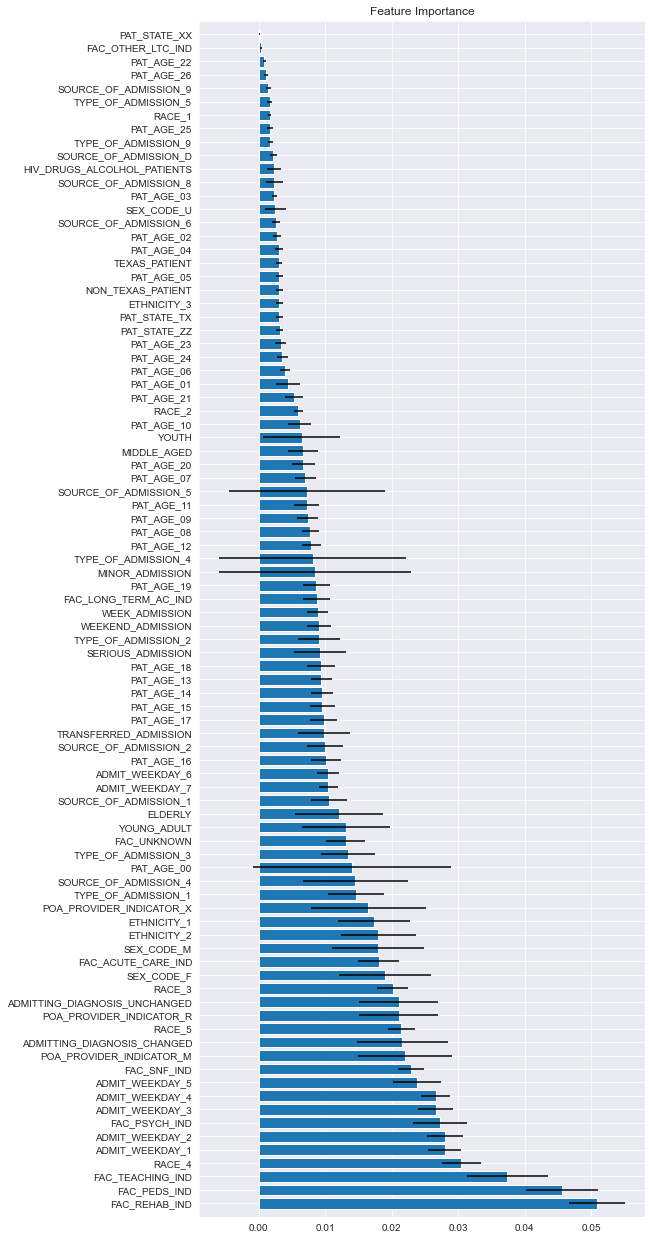

In [193]:
plt.figure(figsize=(8,22))
plt.title("Feature Importance")
plt.barh(range(importances.shape[0]), importances[indices], xerr=std[indices], align='center')
plt.yticks(range(importances.shape[0]), feature_names)
plt.ylim([-1, importances.shape[0]])
plt.show()

### 1.5.1.1 Delete Unimportant Features

In [194]:
unimportant_features = []
for f in range(importances.shape[0]):
    if importances[indices[f]] < 0.0035:
        unimportant_features.append(feature_names[f])
        print("Feature %30s has low importance (%f)" % (feature_names[f], importances[indices[f]]))
    
    if std[indices[f]] > importances[indices[f]]:
        if feature_names[f] not in unimportant_features:
            unimportant_features.append(feature_names[f])
            print("Feature %30s has noise (%f) greater than importance (%f)" % (feature_names[f], std[indices[f]], importances[indices[f]]))

df_X_train_new_model = df_X_train_model
df_X_test_new_model = df_X_test_model

df_y_train_new_model = df_y_train
df_y_test_new_model = df_y_test

df_X_train_new_model.drop(columns=unimportant_features, inplace=True, errors='ignore')
df_X_test_new_model.drop(columns=unimportant_features, inplace=True, errors='ignore')

df_y_train_new_model.drop(columns=unimportant_features, inplace=True, errors='ignore')
df_y_test_new_model.drop(columns=unimportant_features, inplace=True, errors='ignore')

X_train, y_train = df_X_train_new_model.values, df_y_train_new_model.values
X_test, y_test = df_X_test_new_model.values, df_y_test_new_model.values

Feature                     PAT_AGE_00 has noise (0.014948) greater than importance (0.014012)
Feature                MINOR_ADMISSION has noise (0.014383) greater than importance (0.008439)
Feature            TYPE_OF_ADMISSION_4 has noise (0.014031) greater than importance (0.008084)
Feature          SOURCE_OF_ADMISSION_5 has noise (0.011728) greater than importance (0.007177)
Feature                     PAT_AGE_23 has low importance (0.003280)
Feature                   PAT_STATE_ZZ has low importance (0.003148)
Feature                   PAT_STATE_TX has low importance (0.003091)
Feature                    ETHNICITY_3 has low importance (0.003087)
Feature              NON_TEXAS_PATIENT has low importance (0.003083)
Feature                     PAT_AGE_05 has low importance (0.003069)
Feature                  TEXAS_PATIENT has low importance (0.003062)
Feature                     PAT_AGE_04 has low importance (0.003008)
Feature                     PAT_AGE_02 has low importance (0.002756)

### 1.5.1.2 Retrain

In [195]:
metric = 'recall_macro'
for name, clf in classifiers.items():
    clf.fit(X_train, y_train)
    training_score = cross_val_score(clf, X_train, y_train, cv=10, n_jobs=-1,
        scoring=metric)
    
    print("%30s has a training score (%s) of %.2f%% " % (name, metric, 100*training_score.mean()))

          LogisticRegressionV1 has a training score (recall_macro) of 49.17% 
          LogisticRegressionV2 has a training score (recall_macro) of 49.25% 
       ExtraTreeClassifierBase has a training score (recall_macro) of 45.44% 
         ExtraTreeClassifierV1 has a training score (recall_macro) of 48.11% 
         ExtraTreeClassifierV2 has a training score (recall_macro) of 48.51% 
         ExtraTreeClassifierV3 has a training score (recall_macro) of 48.41% 
             BaggingClassifier has a training score (recall_macro) of 49.97% 
                      AdaBoost has a training score (recall_macro) of 48.73% 


### 1.5.2 Metrics

In [196]:
# pd.crosstab(df_pred.true.map(target_labels), df_pred[model].map(target_labels), rownames=['True'], colnames=['Predicted'])

In [197]:
# from sklearn.metrics import classification_report 
# print(classification_report(df_pred.true, df_pred[model], target_names=le_target.inverse_transform([0,1,2])))

### 1.5.3 Hyper-Parameter Tuning

In [198]:
from sklearn.model_selection import GridSearchCV

param_space = {
    
    "LogisticRegression": {
        "solver":["liblinear"],
        "penalty": ['l1', 'l2'], 
        "C": [0.001, 0.01, 0.1, 1, 10, 100, 1000]
    },
    
    "ExtraTreeClassifier": {
        "n_estimators":[200, 500],
        "max_features":["auto", "sqrt", "log2"],
        "min_samples_split":[2,5,10],
        "max_depth": [6,7,8],
        "criterion":["gini", "entropy"],
        "bootstrap":[True, False]
    },
    "BaggingClassifier": {
        "max_samples": [0.5, 1.0],
        "max_features": [1, 2, 4],
        "bootstrap": [True, False],
        "bootstrap_features": [True, False]
    }
}
    

best_classifiers = {}

In [199]:
if HYPER_TUNING == True:

    for name, clf in classifiers.items():

        param = param_space[name]
        print("\n\nPerforming GridSearchCV on %s..." % name)
        clf = GridSearchCV(classifiers[name], param, cv=5, scoring=metric )

        clf.fit(X_train, y_train)
        best_classifiers[name] = clf

        score = cross_val_score(clf, X_train, y_train, cv=10)
        print(best_classifiers[name])
        print("%s Cross Validation Score (%s): %.2f%%" % (name, metric, 100*score.mean()))

        print("\nBest Params: \n")
        print(best_classifiers[name].best_params_)

In [200]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import f1_score

if HYPER_TUNING == True:

    best_classifier_pred = {}
    for name in classifiers:
        pred = cross_val_predict(best_classifiers[name], X_train, y_train, cv=10)
        best_classifier_pred[name] = pred

    best_classifier_pred['true'] = y_train
    df_best_pred = pd.DataFrame(best_classifier_pred)

## 1.6 Grading

In [201]:
df.to_csv("data/test.csv", index=False)

In [202]:
df_grading = pd.read_csv(f"data/grading.csv", dtype=str)
df_grading.shape

(100000, 193)

In [203]:
df_grading = pd.merge(df_grading, df_facility, on="THCIC_ID", how="left")
df_grading.shape

(100000, 202)

In [204]:
df_grading["FAC_UNKNOWN"] = df_grading.FAC_OTHER_LTC_IND.isnull().astype(int)

for c in df.columns:
    if c [:3]=="FAC":
        df_grading[c].fillna(0, inplace=True)

### 1.6.1. Encoding `df_grading`

In [205]:
my_lib.clean_categories(df_grading)

Feature TYPE_OF_ADMISSION -> ['2' '1' '3' '4' '5' '9']
Feature SOURCE_OF_ADMISSION -> ['1' '2' '5' '6' 'D' '4' '8' '9' '0']
Feature PAT_STATE -> ['TX' 'ZZ' 'XX']
Feature SEX_CODE -> ['F' 'M' 'U']
Feature RACE -> ['4' '5' '3' '2' '1']
Feature ETHNICITY -> ['1' '2' '3']


In [206]:
feature_engineering(df_grading)

cat_features = ["TYPE_OF_ADMISSION","SOURCE_OF_ADMISSION","PAT_STATE", "SEX_CODE", "RACE", "ETHNICITY", "ADMIT_WEEKDAY", "PAT_AGE", "POA_PROVIDER_INDICATOR"]
bool_features = ["ADMITTING_DIAGNOSIS_UNCHANGED", 
                 "ADMITTING_DIAGNOSIS_CHANGED", 
                 "SERIOUS_ADMISSION",
                 "MINOR_ADMISSION",
                 "WEEKEND_ADMISSION", 
                 "WEEK_ADMISSION", 
                 "TEXAS_PATIENT", 
                 "NON_TEXAS_PATIENT", 
                 "ELDERLY",
                 "MIDDLE_AGED",
                 "YOUNG_ADULT",
                 "YOUTH",
                 "HIV_DRUGS_ALCOLHOL_PATIENTS",
                 "TRANSFERRED_ADMISSION"
                ] + [c for c in df.columns if c[:3]=="FAC"]

df_X_train_model, df_X_test_model = encode_features(df_X_train, df_grading, cat_LabelBinarize=cat_features, bool_features=bool_features)

### 1.6.2. Make Predictions

In [207]:
model = "BaggingClassifier"
df_grading['TARGET'] = classifiers[model].fit(df_X_train_model, y_train).predict(df_X_test_model)
df_grading['TARGET'] = df_grading['TARGET'].map(target_labels)

### 1.6.3. Save Predictions

In [208]:
df_grading.loc[:, ["RECORD_ID", "TARGET"]].to_csv("df_grading_pred.csv", index=False)

### 1.6.4. Generate Archive

In [209]:
my_lib.make_assignment()

Creating archive: my_assignment.zip
	01-Import.ipynb - OK
	02-EDA.ipynb - OK
	03-Model.ipynb - OK
	my_lib.py - OK
	df_grading_pred.csv - OK
